## Dependencies

In [1]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,random_split
from torchvision.transforms import transforms
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
os.chdir('../')

In [2]:
%pwd

'c:\\Projects\\python\\brain_tumor_segmentation'

In [ ]:
from src.utils import DiceLoss, CustomDataLoader, BrainTumorSegmentationDataset, BCEDiceLoss, dice_coefficient
from src.model1 import UNet

In [ ]:
## Global parameters
H,W = 256,256
torch.manual_seed(42)
batch_size = 16
lr = 1e-3
num_epochs = 500
dataset_path = "./data/archive/"
model_dir = './models/model1/'
os.makedirs(model_dir,exist_ok=True)
model_path = os.path.join(model_dir, 'best_model.pt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


## Data exploration

In [5]:
image_dir = os.path.join(dataset_path,'images')
mask_dir = os.path.join(dataset_path,'masks')
images = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
masks = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])

print(len(images),len(masks))
for i in range(5):
    print(images[i],masks[i])

3064 3064
./data/archive/images\1.png ./data/archive/masks\1.png
./data/archive/images\10.png ./data/archive/masks\10.png
./data/archive/images\100.png ./data/archive/masks\100.png
./data/archive/images\1000.png ./data/archive/masks\1000.png
./data/archive/images\1001.png ./data/archive/masks\1001.png


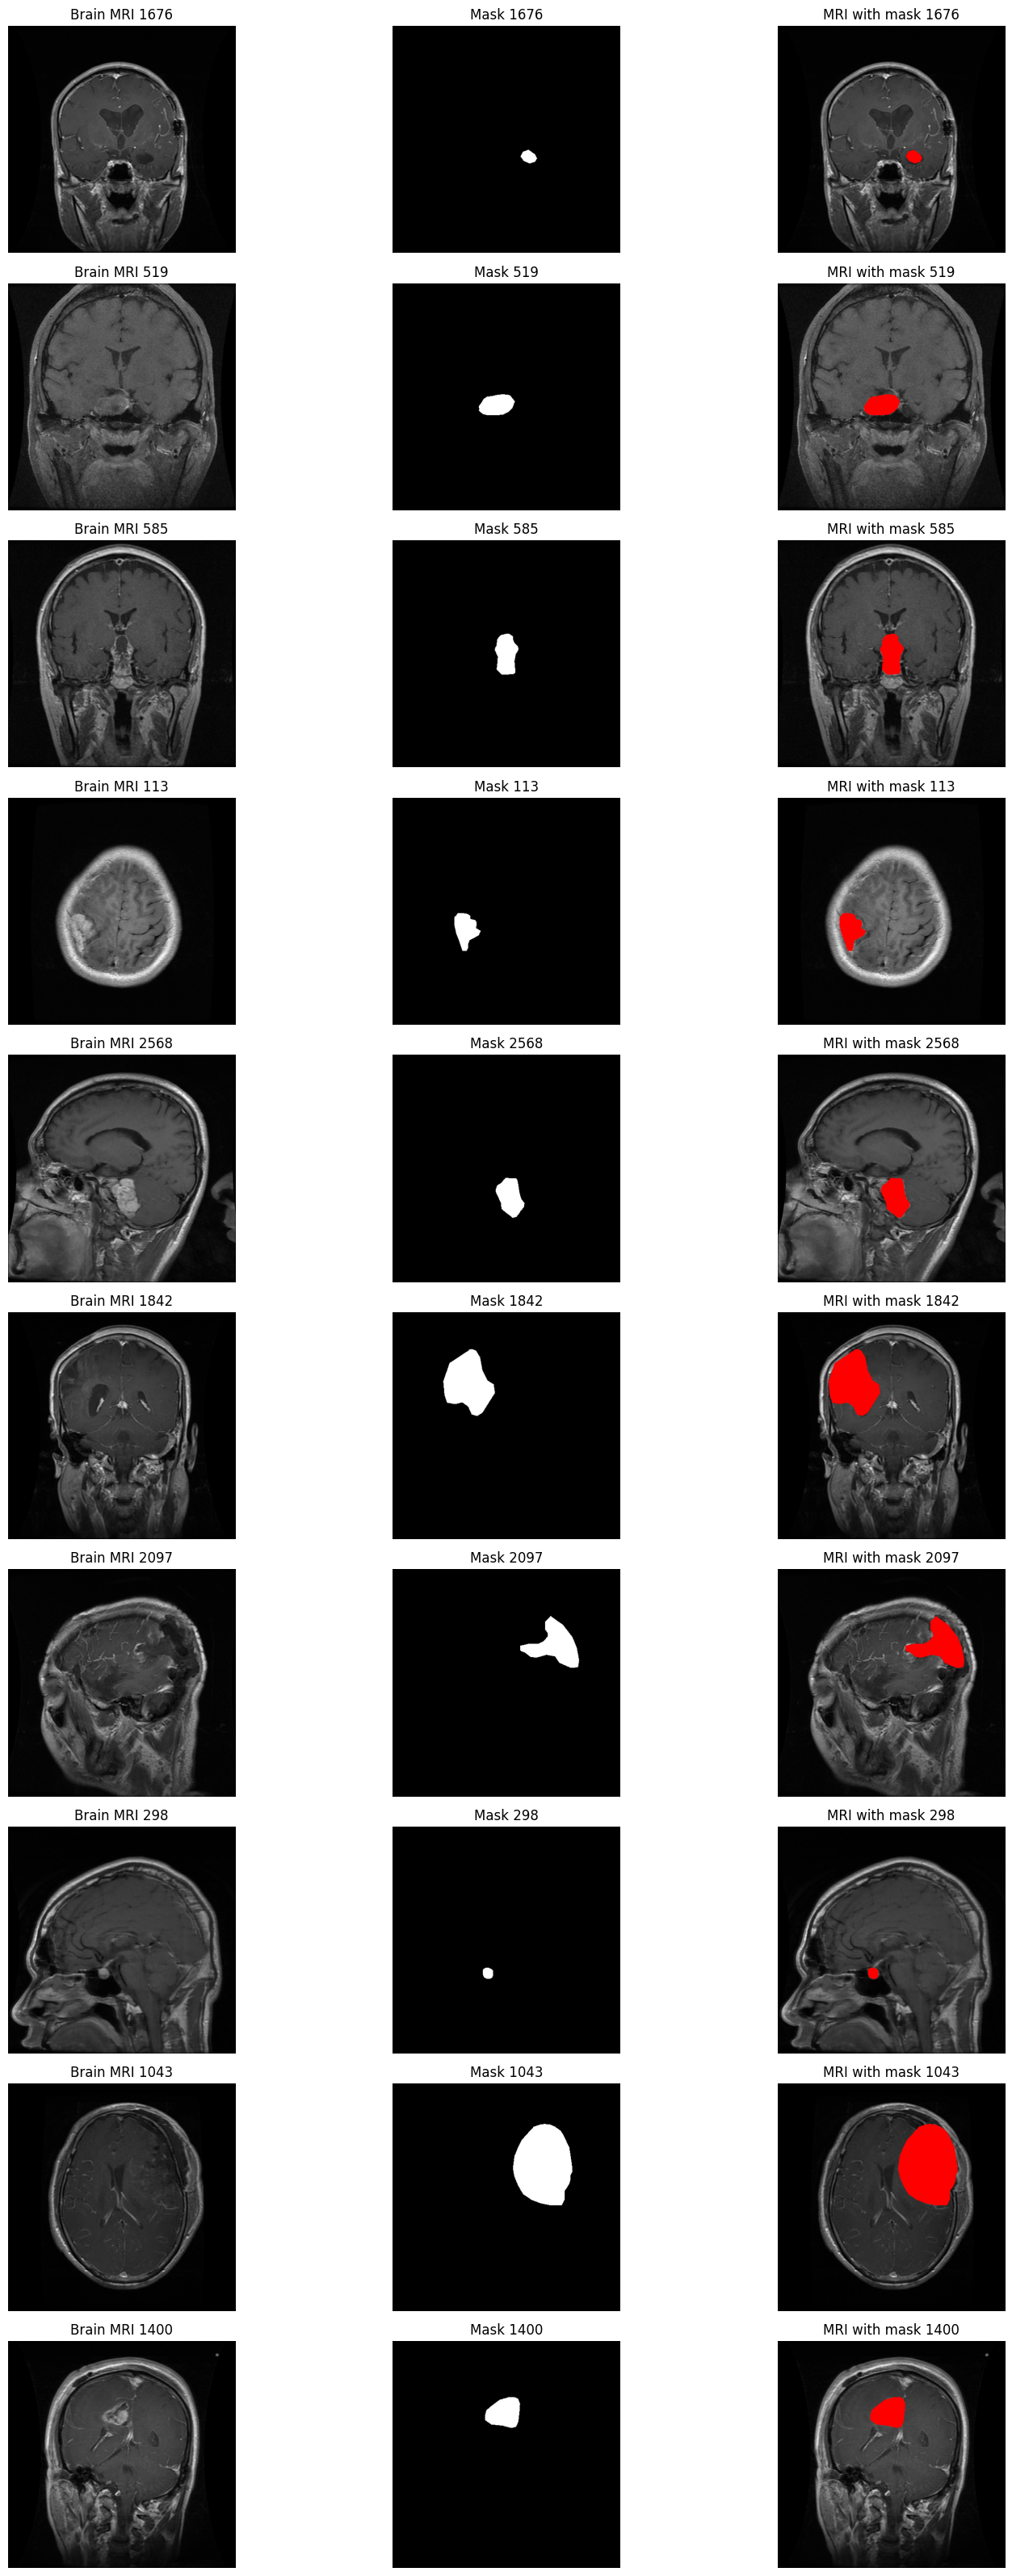

In [6]:
fig, axs = plt.subplots(10, 3, figsize=(16, 32))

for idx in range(10):
    i = random.randint(0, len(images) - 1)
    
    # 1) Read the MRI image and convert to RGB
    mri_pil = Image.open(images[i]).convert("RGB")  # Ensure it's in RGB format
    
    # 2) Read the mask in grayscale
    mask_pil = Image.open(masks[i]).convert("L")  # "L" mode for grayscale

    axs[idx, 0].set_title(f"Brain MRI {i}")
    axs[idx, 1].set_title(f"Mask {i}")
    axs[idx, 2].set_title(f"MRI with mask {i}")

    axs[idx, 0].imshow(mri_pil)

    axs[idx, 1].imshow(mask_pil, cmap="gray")

    # Convert images to NumPy for overlaying
    mri_np = np.array(mri_pil)
    mask_np = np.array(mask_pil)

    overlay = mri_np.copy()
    overlay[mask_np == 255] = [255, 0, 0]  # Color the "255" regions in red

    axs[idx, 2].imshow(overlay)

    # Hide axes
    axs[idx, 0].axis("off")
    axs[idx, 1].axis("off")
    axs[idx, 2].axis("off")

plt.tight_layout()
plt.show()


## Model Training

### Train function 1

In [7]:
# def train_UNet(model,train_loader,valid_loader,device,num_epochs:int=500,lr:float=1e-4,patience=20,log_path='./logs/train_log.csv',model_path='./models/model1/best_model.pth'):
#     criterion = DiceLoss()
#     optimizer = optim.Adam(params=model.parameters(),lr=lr)
#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
#                                                      mode='min',
#                                                      patience=patience,
#                                                      verbose=True,
#                                                      min_lr=1e-7)
#     best_loss = float('inf')
#     patience_counter = 0
#     model.to(device)

#     with open(log_path, mode='w', newline='') as f:
#         writer = csv.writer(f)
#         writer.writerow(["Epoch", "Train Loss", "Valid Loss"])

#     #train loop begins

#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0.0
#         total_train_samples = 0

#         for images,masks in train_loader:
#             images,masks = images.to(device), masks.to(device)
#             batch_size = images.size(0)
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs,masks)
#             train_loss+=loss.item() *batch_size
#             total_train_samples+=batch_size
#             loss.backward()
#             optimizer.step()
        
#         train_loss=train_loss/total_train_samples

#         model.eval()
#         valid_loss = 0.0
#         total_valid_samples = 0
#         with torch.no_grad():
#             for images,masks in valid_loader:
#                 images,masks = images.to(device),masks.to(device)
#                 batch_size = images.size(0)
#                 outputs = model(images)
#                 loss = criterion(outputs,masks)
#                 valid_loss+=loss.item()*batch_size
#                 total_valid_samples+=batch_size
        
#         valid_loss=valid_loss/total_valid_samples
        
#         scheduler.step(valid_loss)
#         print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

#         with open(log_path, mode='a', newline='') as f:
#             writer = csv.writer(f)
#             writer.writerow([epoch + 1, train_loss, valid_loss])

#         if valid_loss<best_loss:
#             best_loss=valid_loss
#             torch.save(model.state_dict(),model_path)
#             patience_counter = 0
#         else:
#             patience_counter+=1
        
#         if patience_counter>=patience:
#             print("Early Stopping triggered!")
#             break


### Train function 2

In [ ]:
def train_UNet(model, train_loader, valid_loader, device, num_epochs=500, lr=1e-3,
               log_path='./logs/train_log.csv', model_path='./models/model1/best_model.pth'):
    # Use the combined BCE + Dice loss (ensure that BCEDiceLoss is defined/imported)
    criterion = BCEDiceLoss()
    
    # Adam with weight decay for regularization
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    # Cosine annealing scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-7)
    
    best_loss = float('inf')
    model.to(device)

    # Open log file and write header (including Valid Dice)
    with open(log_path, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Epoch", "Train Loss", "Valid Loss", "Valid Dice"])

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        total_train_samples = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            batch_size_curr = images.size(0)
            train_loss += loss.item() * batch_size_curr
            total_train_samples += batch_size_curr
        
        train_loss = train_loss / total_train_samples

        model.eval()
        valid_loss = 0.0
        total_valid_samples = 0
        valid_dice = 0.0

        with torch.no_grad():
            for images, masks in valid_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                batch_size_curr = images.size(0)
                valid_loss += loss.item() * batch_size_curr
                total_valid_samples += batch_size_curr

                # Compute dice coefficient for the batch and accumulate
                batch_dice = dice_coefficient(outputs, masks)
                valid_dice += batch_dice * batch_size_curr

        valid_loss = valid_loss / total_valid_samples
        valid_dice = valid_dice / total_valid_samples
        
        # Step the cosine annealing scheduler
        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, "
              f"Valid Loss: {valid_loss:.4f}, Valid Dice: {valid_dice:.4f}")

        with open(log_path, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch + 1, train_loss, valid_loss, valid_dice])

        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), model_path)


cuda


### Trainer code

In [9]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor()
])

full_dataset = BrainTumorSegmentationDataset(
    image_dir=os.path.join(dataset_path, "images"), 
    mask_dir=os.path.join(dataset_path, "masks"),
    transform=transform
)

# Split dataset
train_size = int(0.6 * len(full_dataset))
valid_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])

train_loader = CustomDataLoader(train_dataset,batch_size=16,shuffle=True)
valid_loader = CustomDataLoader(valid_dataset,batch_size=16,shuffle=True)


#### Visualize train loader

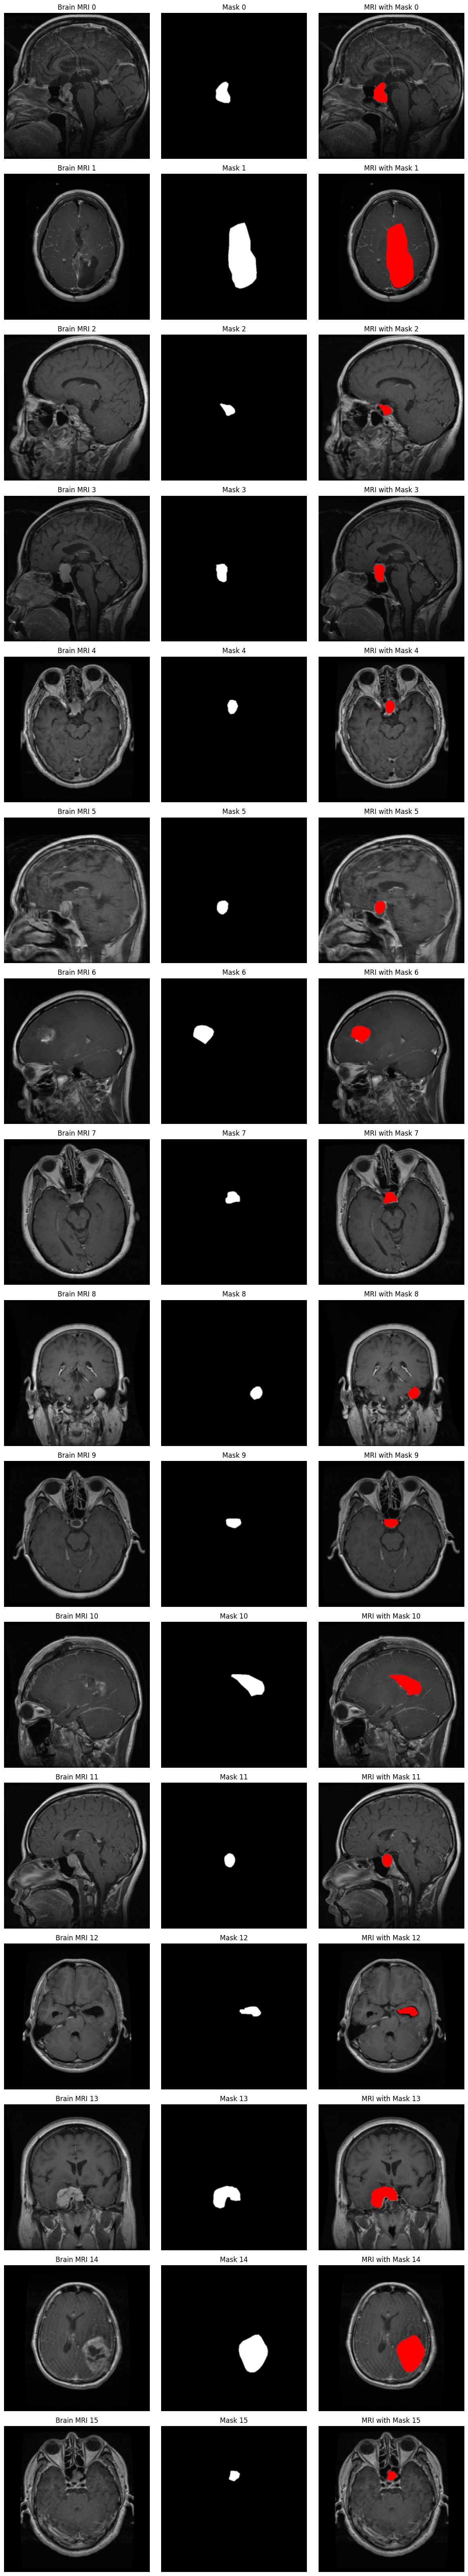

In [10]:
# Fetch a single batch
batch = next(iter(train_loader))
images, masks = batch

# Convert tensors to numpy for visualization
images = images.permute(0, 2, 3, 1).cpu().numpy()  # Convert (B, C, H, W) → (B, H, W, C)
masks = masks.squeeze(1).cpu().numpy()  # Convert (B, 1, H, W) → (B, H, W)

batch_size = images.shape[0]
cols = 3  # 3 columns: Image, Mask, Overlay
rows = batch_size  # One row per sample

fig, axs = plt.subplots(rows, cols, figsize=(12, 4 * batch_size))

for idx in range(batch_size):
    # Display MRI image
    axs[idx, 0].imshow(images[idx])
    axs[idx, 0].set_title(f"Brain MRI {idx}")
    
    # Display mask
    axs[idx, 1].imshow(masks[idx], cmap='gray')
    axs[idx, 1].set_title(f"Mask {idx}")
    
    # Overlay mask on MRI
    overlay = images[idx].copy()
    overlay[masks[idx] == 1] = [1, 0, 0]  # Set mask regions to red

    axs[idx, 2].imshow(overlay)
    axs[idx, 2].set_title(f"MRI with Mask {idx}")

    # Hide axes
    axs[idx, 0].axis("off")
    axs[idx, 1].axis("off")
    axs[idx, 2].axis("off")

plt.tight_layout()
plt.show()


In [11]:
for images, masks in train_loader:
    print(f"Image shape: {images.shape}, Mask shape: {masks.shape}")
    break 

Image shape: torch.Size([16, 3, 256, 256]), Mask shape: torch.Size([16, 1, 256, 256])


## Train

In [12]:
model = UNet()
train_UNet(model, train_loader, valid_loader, device, num_epochs, lr, model_path=model_path)

Epoch 1/500, Train Loss: 1.1905, Valid Loss: 1.0739, Valid Dice: 0.0769


KeyboardInterrupt: 